## Setup

### Install the client library

In [43]:
!pip install -q google-generativeai

### Import libraries

In [44]:
import google.generativeai as genai
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [46]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

## Create tuned model

In [12]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [14]:
name = "name-wanderizer"
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    training_data=[
        {
             'text_input': '1',
             'output': '2',
        },{
             'text_input': '3',
             'output': '4',
        },{
             'text_input': '-3',
             'output': '-2',
        },{
             'text_input': 'twenty two',
             'output': 'twenty three',
        },{
             'text_input': 'two hundred',
             'output': 'two hundred one',
        },{
             'text_input': 'ninety nine',
             'output': 'one hundred',
        },{
             'text_input': '8',
             'output': '9',
        },{
             'text_input': '-98',
             'output': '-97',
        },{
             'text_input': '1,000',
             'output': '1,001',
        },{
             'text_input': '10,100,000',
             'output': '10,100,001',
        },{
             'text_input': 'thirteen',
             'output': 'fourteen',
        },{
             'text_input': 'eighty',
             'output': 'eighty one',
        },{
             'text_input': 'one',
             'output': 'two',
        },{
             'text_input': 'three',
             'output': 'four',
        },{
             'text_input': 'seven',
             'output': 'eight',
        }
    ],
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [25]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-5159',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2025, 5, 12, 9, 35, 13, 874208, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 5, 12, 9, 37, 17, 76104, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2025, 5, 12, 9, 35, 14, 113699, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                               

In [24]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [23]:
operation.metadata

total_steps: 375
tuned_model: "tunedModels/generate-num-5159"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [28]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/375 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

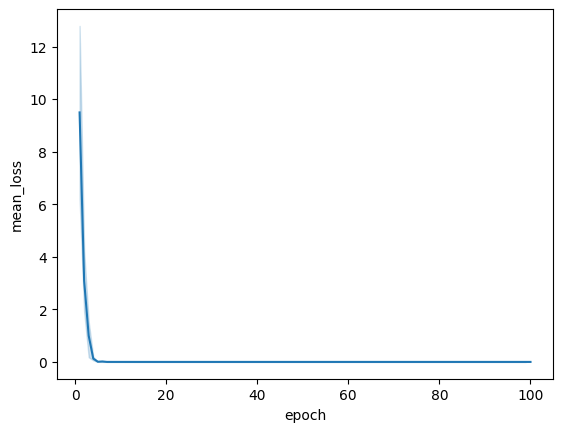

In [29]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [30]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [31]:
result = model.generate_content('55')
result.text

'56'

In [32]:
result = model.generate_content('123455')
result.text

'123456'

In [33]:
result = model.generate_content('four')
result.text

'five'

In [34]:
result = model.generate_content('quatre') # French 4
result.text                               # French 5 is "cinq"

'cinq'

In [35]:
result = model.generate_content('III')    # Roman numeral 3
result.text                               # Roman numeral 4 is IV

'IV'

In [36]:
result = model.generate_content('七')  # Japanese 7
result.text                            # Japanese 8 is 八!

'八'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [37]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [38]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [41]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [42]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-5159?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-5159 does not exist.
